# Connect with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load CT images & Combine CT image with csv column data as the features of the images

In [ ]:
import json

# Open and read the JSON file. Make sure the same laoding sequence of samples as the paper
# update your path for samples.json file
sample_key_path = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/samples.json'

with open(sample_key_path, 'r') as f:
    data = json.load(f)

# Print the dictionary to see its content
print(data)

{'IPP_10__4_0.56_0.837_0.657': 0, 'IPP_30__2_2.16_1.02_0.7049': 1, 'IPP_5__6_0.88_1.241_0.456': 2, 'IPP_5__8_0.97_1.399_0.613': 3, 'R_7_IPP_20__3_3.05_1.114_1.105': 4, 'IPP_40__5_3.56_1.4734_0.872': 5, 'R_1_IPP_20__3_0.8_1.027_1.2': 6, 'R_1_IPP_30__4_2.32_1.562_1.23': 7, 'R_7_IPP_20__5_1.91_1.628_1.082': 8, 'R_10_IPP_20__1_3.44_1.481_1.300': 9, 'R_2_IPP_10__4_0.87_1.526_1.034': 10, 'R_2_IPP_5__6_0.81_1.307_0.794': 11, 'R_1_IPP_10__4_0.39_1.014_0.6422': 12, 'R_1_IPP_20__5_1.89_1.144_1.412': 13, 'R_1_IPP_40__1_4.98_1.411_2.106': 14, 'R_5_IPP_20__1_1.638_1.397_0.955': 15, 'R_10_IPP_20__3_4.46_1.472_1.4132': 16, 'R_2_IPP_40__5_3.39_1.485_1.536': 17, 'R_2_IPP_20__5_1.29_1.313_1.276': 18, 'R_5_IPP_20__5_1.29_1.420_0.769': 19, 'IPP_20__5_1.67_1.423_0.648': 20, 'R_1_IPP_30__2_1.7_1.523_1.423': 21, 'R_2_IPP_20__3_2.17_1.578_1.173': 22, 'R_2_IPP_30__3_4.1_2.113_1.408': 23, 'IPP_5__4_0.44_1.403_0.245': 24, 'R_10_IPP_20__2_2.35_1.354_1.18': 25}


In [ ]:
import os
import gc
import pandas as pd
from PIL import Image
from torchvision.transforms import transforms
import random

from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.model_selection import KFold


import torch
import numpy as np
import random
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedGroupKFold
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, Subset


# Check if CUDA (GPU) is available
cuda_device = 'cuda'  # most people use cuda:0 so let's try to use the other GPU on the machine
device = torch.device(cuda_device if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define the image transforms
image_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


class CustomDatasetV5(torch.utils.data.Dataset):
    def __init__(self, data, device='cpu'):
        self.data = data
        self.device = device
        self.preload_to_device()

    def preload_to_device(self):
        self.data = [(image.to(self.device), group, torch.tensor(label).float().to(self.device),
                      torch.tensor(features).float().to(self.device)) for image, group, label, features in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, group, label, features = self.data[index]
        return image, group, label, features


def make_dataset_v5(data_folder, N=1, train_data= True, verbose=False):

    # Set the random seed
    random.seed(16)

    # Create a list to store the data tuples
    this_data = []

    # Get a list of subfolders in the data folder
    subfolders = os.listdir(data_folder)
    # sample_keys = {k: i for i, k in enumerate(subfolders)}
    if train_data:
        sample_keys = data
    else:
        sample_keys = {k: i for i, k in enumerate(subfolders)}

    # Sort subfolders based on the index after splitting by '_', and [-3] represent the UTS
    subfolders.sort(key=lambda x: float(x.split('_')[-3]))

    # Group subfolders based on i % 5
    grouped_subfolders = [[] for _ in range(5)]
    for i, subfolder in enumerate(subfolders):
        index = i // (len(subfolders)//5)
        if index >=5:
            index -= 1
        grouped_subfolders[index].append(subfolder)
    if verbose:
        print(grouped_subfolders)

    chunk_keys = {}
    for i, gs in enumerate(grouped_subfolders):
        for sf in gs:
            chunk_keys[sf] = i

    # Randomly select one subfolder from each group
    for _ in range(len(subfolders) // 5 +1):
        for k, group in enumerate(grouped_subfolders):
            if group:
                selected_subfolder = random.choice(group)
                group.remove(selected_subfolder)
                folder_path = os.path.join(data_folder, selected_subfolder)

                # Load the CSV data
                csv_data = None
                for file_name in os.listdir(folder_path):
                    if file_name.endswith(".csv"):
                        csv_path = os.path.join(folder_path, file_name)
                        csv_data = pd.read_csv(csv_path)
                        break

                # Load the image data and combine it with the CSV data
                num = 0
                image_names = [image_name for image_name in os.listdir(folder_path) if image_name.endswith(".jpg")]
                image_names.sort()
                # Select every fifth image
                for i, image_name in enumerate(image_names):
                    if i % N != 0:
                        continue
                    num+=1
                    # print(image_name)
                    image_path = os.path.join(folder_path, image_name)
                    image_data = Image.open(image_path).convert("RGB")  # Convert image to RGB mode
                    image_data = image_transforms(image_data)

                    # Find the corresponding row in the CSV data
                    if csv_data is not None:
                        image_index = csv_data[csv_data["Image Name"] == image_name].index[0]
                        image_features = csv_data.iloc[image_index, 1:].values.astype(float)
                        image_label = csv_data.loc[csv_data["Image Name"] == image_name, "UTS (MPa)"].values[0].astype(float)
                    else:
                        image_features = None

                    # print(selected_subfolder, (chunk_keys[selected_subfolder], sample_keys[selected_subfolder]))
                    # Add data to the list
                    this_data.append((image_data, (chunk_keys[selected_subfolder], sample_keys[selected_subfolder]), image_label, image_features))
                if verbose:
                    print(f'Number of images in folder {selected_subfolder}: {num}')

    return CustomDatasetV5(this_data, device= device)

Using device: cpu


In [ ]:
N_skip = 1
TRAIN_VAL_PATH = "/content/drive/MyDrive/Images/Train_val"
train_val_dataset = make_dataset_v5(TRAIN_VAL_PATH, N=N_skip,train_data= True, verbose=False)
TEST_PATH = "/content/drive/MyDrive/Images/Test"
test_dataset = make_dataset_v5(TEST_PATH, N=N_skip, train_data= False, verbose=False)

print(f'Train & Val images: {len(train_val_dataset)}, Test Images: {len(test_dataset )}')

Train & Val images: 2600, Test Images: 500


Display X-ray CT image

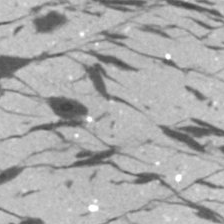

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from IPython.display import display


# Create an instance of the ToPILImage transform
to_pil = ToPILImage()

# Reverse the image in the combined_data list to check how it look
image_tensor, group, image_label, image_features = train_val_dataset[0]
image_pil = to_pil(image_tensor)

# Display the image
display(image_pil)

# PCA embeding for extracted features

In [ ]:
from tqdm import tqdm
def extract_features_from_combined_data(combined_data):
    all_features = []

    for image_data, group, label, column_data in combined_data:

        # Extract features using model
        features = column_data

        # Add extracted features and image features to all_features list
        all_features.append(features)

    return all_features

In [ ]:
import numpy as np

all_features = extract_features_from_combined_data(train_val_dataset)
print(f'{len(all_features[0])} features in each image')
train_features = np.vstack(all_features)
print(f'Shape of training data: {train_features.shape}')
train_labels = np.array(train_features[:,-3])


11 features in each image
Shape of training data: (2600, 11)


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, -100.0, '−100'),
  Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500')])

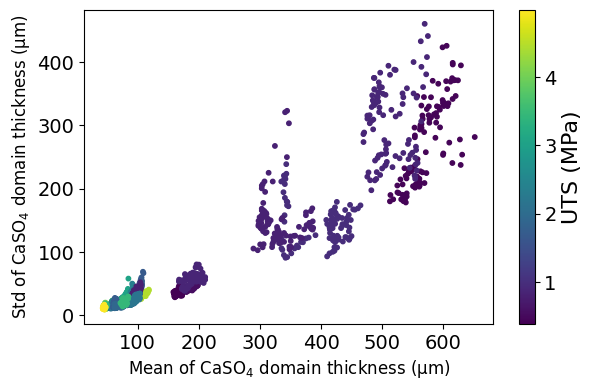

In [ ]:
import matplotlib.pyplot as plt

# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(6.6,4.08))

im = ax.scatter(train_features[:, 2], train_features[:, 3], c=train_features[:,-3], s =10)
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('UTS (MPa)',fontsize=16)   # assign a label to the colorbar
cb.ax.tick_params(labelsize=14)
_ = ax.set_xlabel('Mean of $\mathregular{CaSO_4}$ domain thickness (µm)',fontsize=12)
_ = ax.set_ylabel('Std of $\mathregular{CaSO_4}$ domain thickness (µm)',fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300')])

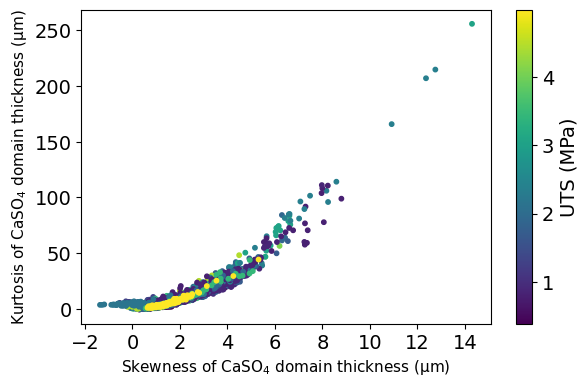

In [ ]:
import matplotlib.pyplot as plt

# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(6.6,4.08))

im = ax.scatter(train_features[:, 6], train_features[:, 7], c=train_features[:,-3], s =10)
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('UTS (MPa)',fontsize=14)   # assign a label to the colorbar
cb.ax.tick_params(labelsize=14)
_ = ax.set_xlabel('Skewness of $\mathregular{CaSO_4}$ domain thickness (µm)',fontsize=11)
_ = ax.set_ylabel('Kurtosis of $\mathregular{CaSO_4}$ domain thickness (µm)',fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.set_aspect('equal')

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700')])

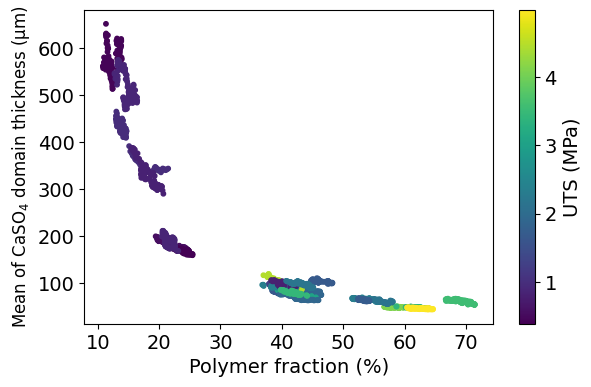

In [ ]:
import matplotlib.pyplot as plt

# plot the principal components of the image features with class labels
fig, ax = plt.subplots(figsize=(6.6,4.08))

im = ax.scatter(train_features[:, 4], train_features[:, 2], c=train_features[:,-3], s =10)
cb = plt.colorbar(im)  # save the output from colorbar
cb.set_label('UTS (MPa)',fontsize=14)   # assign a label to the colorbar
cb.ax.tick_params(labelsize=14)
_ = ax.set_xlabel('Polymer fraction (%)',fontsize=14)
_ = ax.set_ylabel('Mean of $\mathregular{CaSO_4}$ domain thickness (µm)',fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Functions for Training and Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

def calc_mse(model, X, y):
    "Calculate the MSE from a fitted model"
    y_pred = model.predict(X)
    residuals = y_pred - y
    return np.mean(residuals**2)

def calc_r2(model, X, y):
    "Calculate the R-squared value from a fitted model"
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

def parity_plot(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, fold):
    r_squared_train = r2_score(y_train, y_train_pred)
    r_squared_val = r2_score(y_val, y_val_pred)
    r_squared_test = r2_score(y_test, y_test_pred)

    fig, ax = plt.subplots()
    ax.scatter(y_train, y_train_pred, s=30, marker='.', label=f'Train R-squared: {r_squared_train:.4f}', color='tab:blue')
    ax.scatter(y_val, y_val_pred, s=10, marker='*', label=f'Validation R-squared: {r_squared_val:.4f}', color='tab:orange')
    ax.scatter(y_test, y_test_pred, s=10, marker='o', label=f'Test R-squared: {r_squared_test:.4f}', color='red')
    ax.plot([min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
            [min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
            color='black', linestyle='--', label='Ideal fit')
    ax.set_xlabel('True UTS (MPa)')
    ax.set_ylabel('Predicted UTS (MPa)')
    ax.set_aspect('equal')
    ax.set_title(f'Fold {fold+1} Parity Plot')
    ax.legend()
    plt.show()

def train_and_report_performance(model, xtrain, ytrain, xtest, ytest, xval=None, yval=None):
    "Train a model and print MSE results for train and test sets"
    model.fit(xtrain, ytrain)
    train_mse = calc_mse(model, xtrain, ytrain)
    test_mse = calc_mse(model, xtest, ytest)
    train_r2 = calc_r2(model, xtrain, ytrain)
    test_r2 = calc_r2(model, xtest, ytest)
    if xval is not None and yval is not None:
        val_mse = calc_mse(model, xval, yval)
        val_r2 = calc_r2(model, xval, yval)
        print(f'Train MSE = {train_mse:.3f}; Val MSE = {val_mse:.3f}; Test MSE = {test_mse:.3f}')
        print(f'Train R2 = {train_r2:.3f}; Val R2 = {val_r2:.3f}; Test R2 = {test_r2:.3f}')
        return train_mse, val_mse, test_mse, train_r2, val_r2, test_r2
    else:
        print(f'Train MSE = {train_mse:.3f}; Test MSE = {test_mse:.3f}')
        print(f'Train R2 = {train_r2:.3f}; Test R2 = {test_r2:.3f}')
        return train_mse, test_mse, train_r2, test_r2

# Linear Regression

Using device: cpu
Fold 1/5
Train MSE = 0.851; Val MSE = 0.232; Test MSE = 0.396
Train R2 = 0.502; Val R2 = 0.794; Test R2 = 0.703


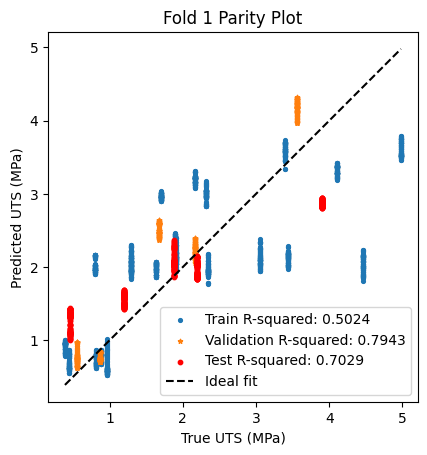

Fold 2/5
Train MSE = 0.710; Val MSE = 0.825; Test MSE = 0.453
Train R2 = 0.523; Val R2 = 0.610; Test R2 = 0.660


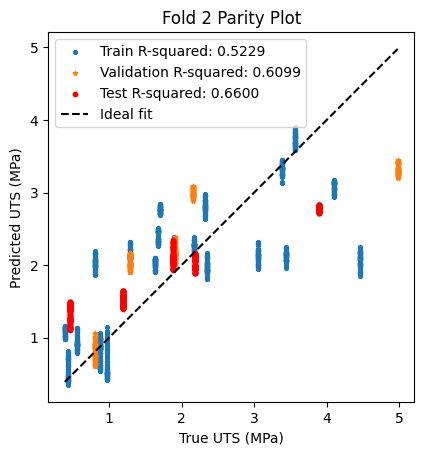

Fold 3/5
Train MSE = 0.491; Val MSE = 1.846; Test MSE = 0.495
Train R2 = 0.676; Val R2 = 0.084; Test R2 = 0.629


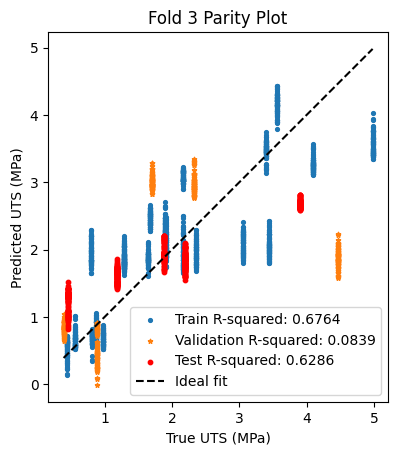

Fold 4/5
Train MSE = 0.793; Val MSE = 0.547; Test MSE = 0.462
Train R2 = 0.521; Val R2 = 0.618; Test R2 = 0.653


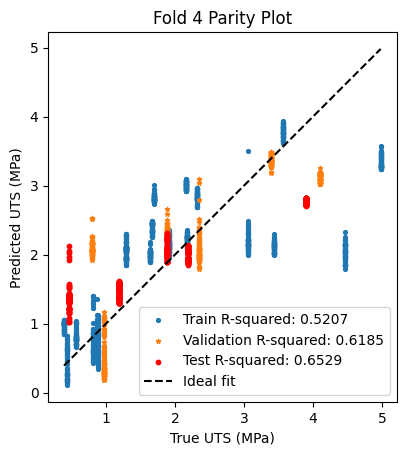

Fold 5/5
Train MSE = 0.704; Val MSE = 0.950; Test MSE = 0.372
Train R2 = 0.587; Val R2 = 0.239; Test R2 = 0.721


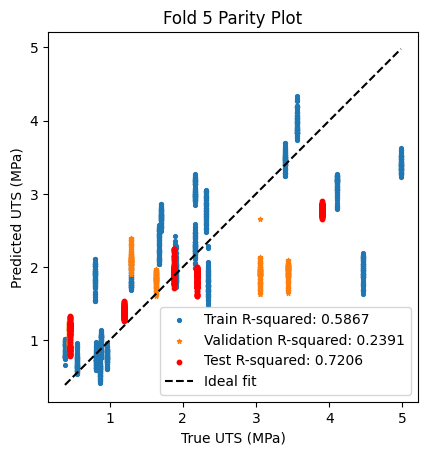

Train MSE average: 0.710 +/- 0.122
Val MSE average: 0.880 +/- 0.543
Test MSE average: 0.436 +/- 0.045
Train R-squared average: 0.562 +/- 0.064
Val R-squared average: 0.469 +/- 0.264
Test R-squared average: 0.673 +/- 0.034


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from PIL import Image
import gc

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
cuda_device = 'cuda:1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

val_xform_list = [transforms.CenterCrop(224)]
params={}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

results_linear = []

# Extract features for classical model training
train_all_features = extract_features_from_combined_data(train_val_dataset)
train_features = np.vstack(train_all_features)
X = train_features[:, 2:8]
y = train_features[:, -3]


# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # record the UTS chunk # when making the dataset
sample_id = [it[1][1] for it in train_val_dataset]  # record the sample # when making the dataset

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold+1}/{n_splits}")
    set_seed(42)

    # Create train and validation datasets for this fold
    train_dataset = Subset(train_val_dataset, train_index)
    val_dataset = Subset(train_val_dataset, val_index)

    # Create train and validation loaders for this fold
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

    # Use these indices to create your training and validation sets
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Test set (assuming you have test_data)
    test_all_features = extract_features_from_combined_data(test_dataset)
    test_features = np.vstack(test_all_features)
    X_test = test_features[:, 2:8]
    y_test = test_features[:, -3]

    # Create and evaluate your model
    model = LinearRegression()
    result = train_and_report_performance(model, X_train, y_train, X_test, y_test, X_val, y_val)

    results_linear.append(result)

    # Generate parity plots for this fold
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    parity_plot(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, fold)

# Calculate averages and standard deviations for MSE and R-squared values
results_linear = np.array(results_linear)
mse_mu_linear = np.mean(results_linear[:, :3], axis=0)
mse_sigma_linear = np.std(results_linear[:, :3], axis=0)
r2_mu_linear = np.mean(results_linear[:, 3:], axis=0)
r2_sigma_linear = np.std(results_linear[:, 3:], axis=0)

# Print out averages and standard deviations for MSE
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} MSE average: {mse_mu_linear[i]:.3f} +/- {mse_sigma_linear[i]:.3f}')

# Print out averages and standard deviations for R-squared
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} R-squared average: {r2_mu_linear[i]:.3f} +/- {r2_sigma_linear[i]:.3f}')

# Polynomial

Fold 1/5
Train MSE = 0.801; Val MSE = 0.143; Test MSE = 0.351
Train R2 = 0.532; Val R2 = 0.873; Test R2 = 0.736


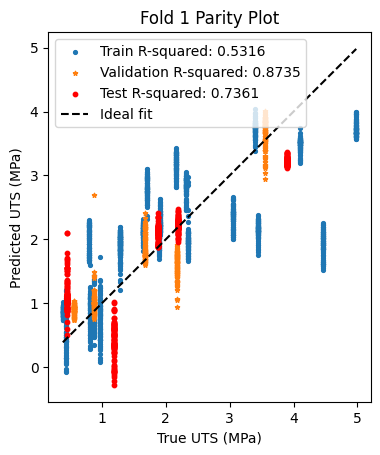

Fold 2/5
Train MSE = 0.633; Val MSE = 0.990; Test MSE = 0.536
Train R2 = 0.574; Val R2 = 0.532; Test R2 = 0.598


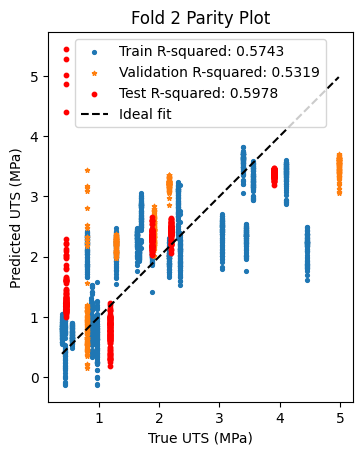

Fold 3/5
Train MSE = 0.370; Val MSE = 2.325; Test MSE = 0.321
Train R2 = 0.757; Val R2 = -0.153; Test R2 = 0.759


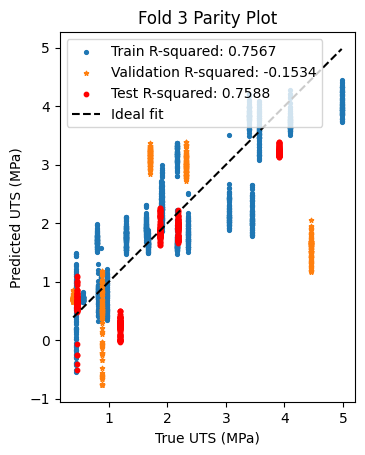

Fold 4/5
Train MSE = 0.698; Val MSE = 0.857; Test MSE = 0.503
Train R2 = 0.578; Val R2 = 0.402; Test R2 = 0.623


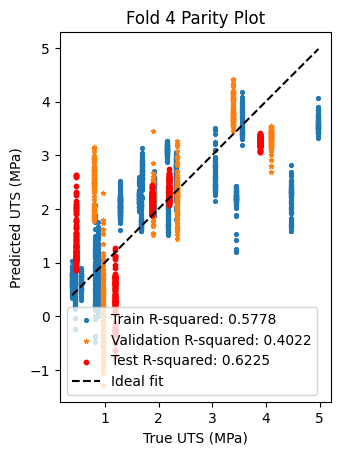

Fold 5/5
Train MSE = 0.637; Val MSE = 1.013; Test MSE = 0.330
Train R2 = 0.626; Val R2 = 0.188; Test R2 = 0.752


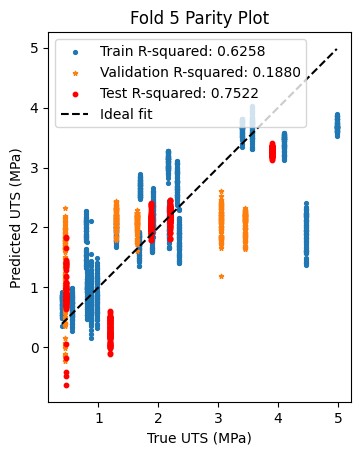

Train MSE average (Poly): 0.628 +/- 0.143
Val MSE average (Poly): 1.066 +/- 0.706
Test MSE average (Poly): 0.408 +/- 0.092
Train R-squared average (Poly): 0.613 +/- 0.078
Val R-squared average (Poly): 0.368 +/- 0.343
Test R-squared average (Poly): 0.693 +/- 0.069


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Polynomial degree (change this value to increase or decrease polynomial complexity)
degree = 2

# Store results for Polynomial regression
results_poly = []

# Assuming you have your data `train_val_data` and `groups_train_val` pre-loaded
train_all_features = extract_features_from_combined_data(train_val_dataset)
train_features = np.vstack(train_all_features)
X = train_features[:, 2:8]
y = train_features[:, -3]


# Create PolynomialFeatures transformer
poly = PolynomialFeatures(degree=degree)

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # record the UTS chunk # when making the dataset
sample_id = [it[1][1] for it in train_val_dataset]  # record the sample # when making the dataset

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold+1}/{n_splits}")
    set_seed(42)

    # Create train and validation datasets for this fold
    train_dataset = Subset(train_val_dataset, train_index)
    val_dataset = Subset(train_val_dataset, val_index)

    # Create train and validation loaders for this fold
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

    # Use these indices to create your training and validation sets
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Test set (assuming you have test_data)
    test_all_features = extract_features_from_combined_data(test_dataset)
    test_features = np.vstack(test_all_features)
    X_test = test_features[:, 2:8]
    y_test = test_features[:, -3]

    # Transform features to polynomial terms for train, val, and test sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Create and evaluate your model
    model = LinearRegression()
    result = train_and_report_performance(model, X_train_poly, y_train, X_test_poly, y_test, X_val_poly, y_val)

    results_poly.append(result)

    # Generate parity plots for this fold
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    y_test_pred = model.predict(X_test_poly)
    parity_plot(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, fold)

# Calculate averages and standard deviations for MSE and R-squared values for Polynomial regression
results_poly = np.array(results_poly)
mse_mu_poly = np.mean(results_poly[:, :3], axis=0)
mse_sigma_poly = np.std(results_poly[:, :3], axis=0)
r2_mu_poly = np.mean(results_poly[:, 3:], axis=0)
r2_sigma_poly = np.std(results_poly[:, 3:], axis=0)

# Print out averages and standard deviations for MSE (Polynomial)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} MSE average (Poly): {mse_mu_poly[i]:.3f} +/- {mse_sigma_poly[i]:.3f}')

# Print out averages and standard deviations for R-squared (Polynomial)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} R-squared average (Poly): {r2_mu_poly[i]:.3f} +/- {r2_sigma_poly[i]:.3f}')


Note: For polynimial, degree = 2 is the best. All degree > 2, will make worse.
Degree = 2,

Train MSE average (Poly): 0.626 +/- 0.125

Val MSE average (Poly): 1.212 +/- 0.496

Test MSE average (Poly): 0.510 +/- 0.207

Train R-squared average (Poly): 0.614 +/- 0.061

Val R-squared average (Poly): 0.181 +/- 0.356

Test R-squared average (Poly): 0.617 +/- 0.155

Degree = 3,

Train MSE average: 0.760 +/- 0.709

Val MSE average: 56.795 +/- 109.959

Test MSE average: 5.115 +/- 4.258

Train R-squared average: 0.533 +/- 0.425

Val R-squared average: -58.902 +/- 117.540

Test R-squared average: -2.841 +/- 3.197

# RandomForest

Fold 1/5
Train MSE = 0.022; Val MSE = 1.039; Test MSE = 0.771
Train R2 = 0.987; Val R2 = 0.080; Test R2 = 0.421


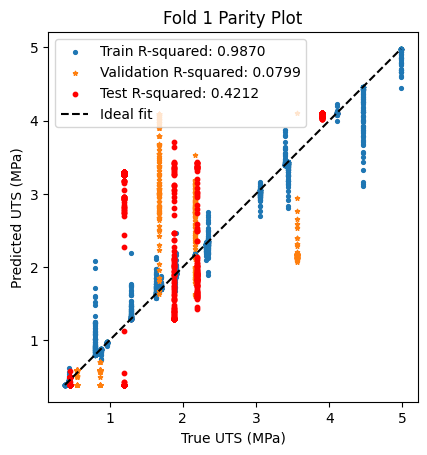

Fold 2/5
Train MSE = 0.022; Val MSE = 1.233; Test MSE = 1.207
Train R2 = 0.985; Val R2 = 0.417; Test R2 = 0.093


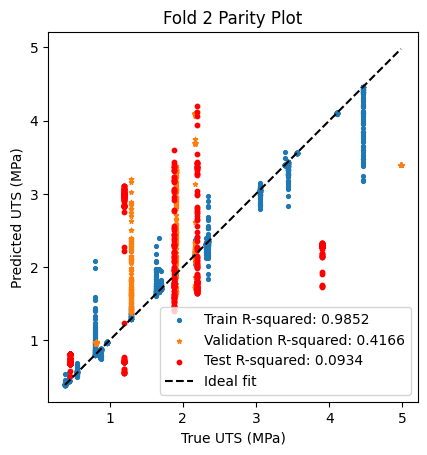

Fold 3/5
Train MSE = 0.007; Val MSE = 1.896; Test MSE = 0.220
Train R2 = 0.995; Val R2 = 0.059; Test R2 = 0.835


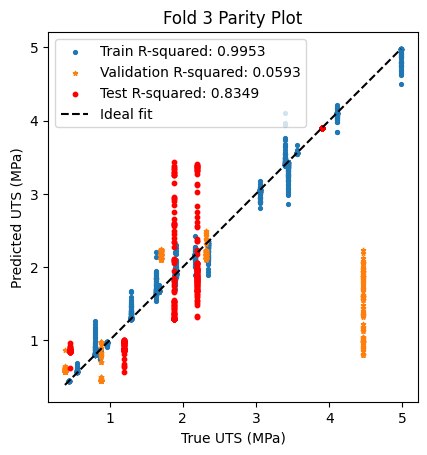

Fold 4/5
Train MSE = 0.009; Val MSE = 3.584; Test MSE = 1.303
Train R2 = 0.995; Val R2 = -1.500; Test R2 = 0.021


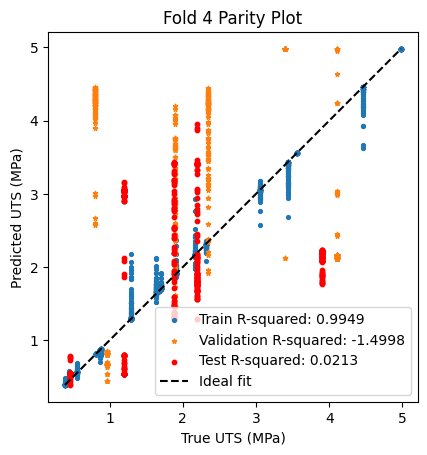

Fold 5/5
Train MSE = 0.018; Val MSE = 0.927; Test MSE = 0.489
Train R2 = 0.989; Val R2 = 0.257; Test R2 = 0.633


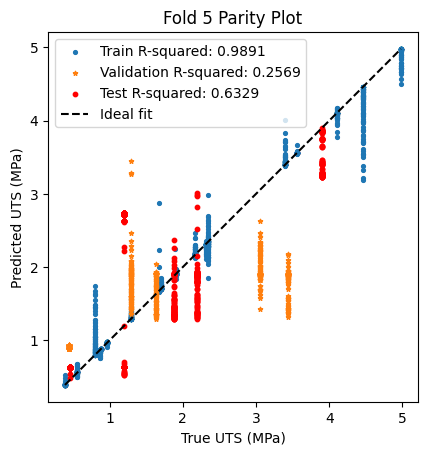

Train MSE average (RF): 0.016 +/- 0.007
Val MSE average (RF): 1.736 +/- 0.983
Test MSE average (RF): 0.798 +/- 0.413
Train R-squared average (RF): 0.990 +/- 0.004
Val R-squared average (RF): -0.137 +/- 0.693
Test R-squared average (RF): 0.401 +/- 0.310


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import DataLoader, Subset

# Store results for Random Forest regression
results_rf = []

# Assuming you have your data `train_val_data` and `groups_train_val` pre-loaded
train_all_features = extract_features_from_combined_data(train_val_dataset)
train_features = np.vstack(train_all_features)
X = train_features[:, 2:8]
y = train_features[:, -3]

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # record the UTS chunk when making the dataset
sample_id = [it[1][1] for it in train_val_dataset]  # record the sample when making the dataset

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold+1}/{n_splits}")
    set_seed(42)

    # Create train and validation datasets for this fold
    train_dataset = Subset(train_val_dataset, train_index)
    val_dataset = Subset(train_val_dataset, val_index)

    # Create train and validation loaders for this fold
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

    # Use these indices to create your training and validation sets
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Test set (assuming you have test_data)
    test_all_features = extract_features_from_combined_data(test_dataset)
    test_features = np.vstack(test_all_features)
    X_test = test_features[:, 2:8]
    y_test = test_features[:, -3]

    # Create and evaluate your model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    result = train_and_report_performance(model, X_train, y_train, X_test, y_test, X_val, y_val)

    results_rf.append(result)

    # Generate parity plots for this fold
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    parity_plot(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, fold)

# Calculate averages and standard deviations for MSE and R-squared values for Random Forest regression
results_rf = np.array(results_rf)
mse_mu_rf = np.mean(results_rf[:, :3], axis=0)
mse_sigma_rf = np.std(results_rf[:, :3], axis=0)
r2_mu_rf = np.mean(results_rf[:, 3:], axis=0)
r2_sigma_rf = np.std(results_rf[:, 3:], axis=0)

# Print out averages and standard deviations for MSE (Random Forest)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} MSE average (RF): {mse_mu_rf[i]:.3f} +/- {mse_sigma_rf[i]:.3f}')

# Print out averages and standard deviations for R-squared (Random Forest)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} R-squared average (RF): {r2_mu_rf[i]:.3f} +/- {r2_sigma_rf[i]:.3f}')


# SVM-SVR

Fold 1/5
Train MSE = 0.931; Val MSE = 0.235; Test MSE = 0.350
Train R2 = 0.455; Val R2 = 0.792; Test R2 = 0.737


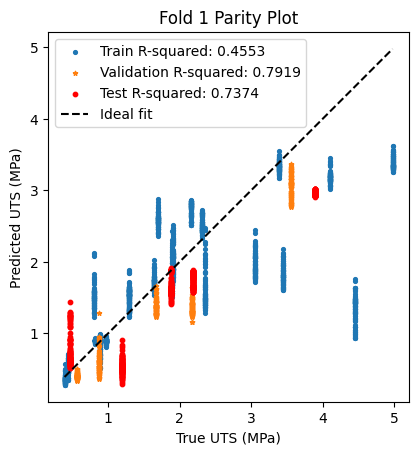

Fold 2/5
Train MSE = 0.698; Val MSE = 0.684; Test MSE = 0.277
Train R2 = 0.531; Val R2 = 0.677; Test R2 = 0.792


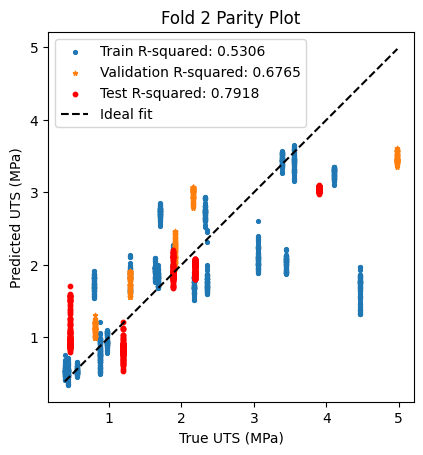

Fold 3/5
Train MSE = 0.408; Val MSE = 2.168; Test MSE = 0.274
Train R2 = 0.732; Val R2 = -0.075; Test R2 = 0.795


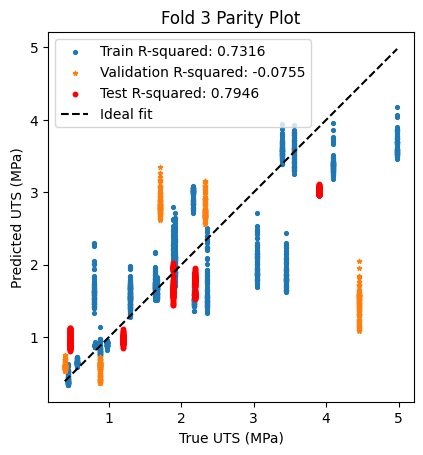

Fold 4/5
Train MSE = 0.866; Val MSE = 0.479; Test MSE = 0.521
Train R2 = 0.476; Val R2 = 0.666; Test R2 = 0.609


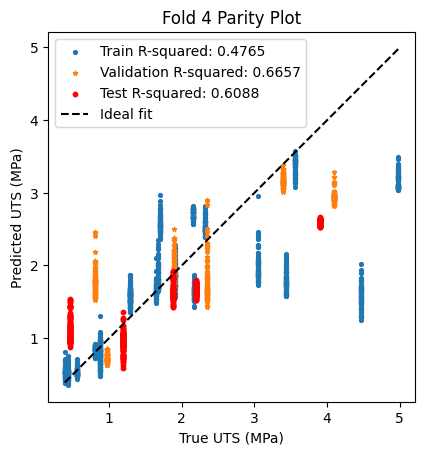

Fold 5/5
Train MSE = 0.725; Val MSE = 0.958; Test MSE = 0.373
Train R2 = 0.574; Val R2 = 0.232; Test R2 = 0.720


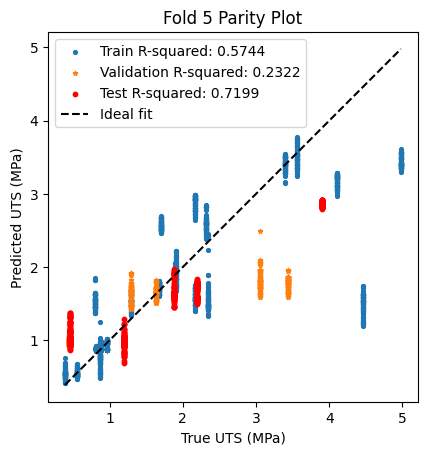

Train MSE average (SVR): 0.726 +/- 0.181
Val MSE average (SVR): 0.905 +/- 0.675
Test MSE average (SVR): 0.359 +/- 0.090
Train R-squared average (SVR): 0.554 +/- 0.098
Val R-squared average (SVR): 0.458 +/- 0.328
Test R-squared average (SVR): 0.731 +/- 0.068


In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, Subset

# Store results for SVR
results_svr = []

# Assuming you have your data `train_val_data` and `groups_train_val` pre-loaded
train_all_features = extract_features_from_combined_data(train_val_dataset)
train_features = np.vstack(train_all_features)
X = train_features[:, 2:8]
y = train_features[:, -3]

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # record the UTS chunk when making the dataset
sample_id = [it[1][1] for it in train_val_dataset]  # record the sample when making the dataset

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold+1}/{n_splits}")
    set_seed(42)

    # Create train and validation datasets for this fold
    train_dataset = Subset(train_val_dataset, train_index)
    val_dataset = Subset(train_val_dataset, val_index)

    # Create train and validation loaders for this fold
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

    # Use these indices to create your training and validation sets
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Test set (assuming you have test_data)
    test_all_features = extract_features_from_combined_data(test_dataset)
    test_features = np.vstack(test_all_features)
    X_test = test_features[:, 2:8]
    y_test = test_features[:, -3]

    # Create and evaluate your SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    result = train_and_report_performance(model, X_train, y_train, X_test, y_test, X_val, y_val)

    results_svr.append(result)

    # Generate parity plots for this fold
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    parity_plot(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, fold)

# Calculate averages and standard deviations for MSE and R-squared values for SVR
results_svr = np.array(results_svr)
mse_mu_svr = np.mean(results_svr[:, :3], axis=0)
mse_sigma_svr = np.std(results_svr[:, :3], axis=0)
r2_mu_svr = np.mean(results_svr[:, 3:], axis=0)
r2_sigma_svr = np.std(results_svr[:, 3:], axis=0)

# Print out averages and standard deviations for MSE (SVR)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} MSE average (SVR): {mse_mu_svr[i]:.3f} +/- {mse_sigma_svr[i]:.3f}')

# Print out averages and standard deviations for R-squared (SVR)
for i, s in enumerate(['Train', 'Val', 'Test']):
    print(f'{s} R-squared average (SVR): {r2_mu_svr[i]:.3f} +/- {r2_sigma_svr[i]:.3f}')


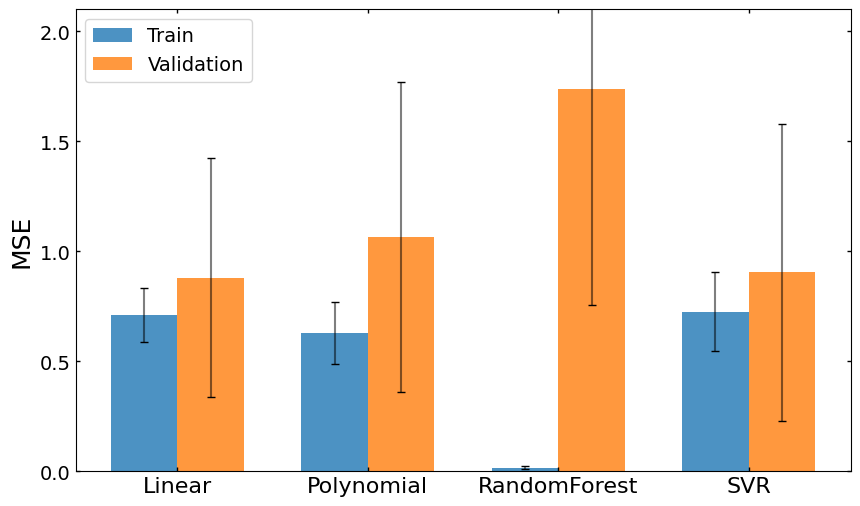

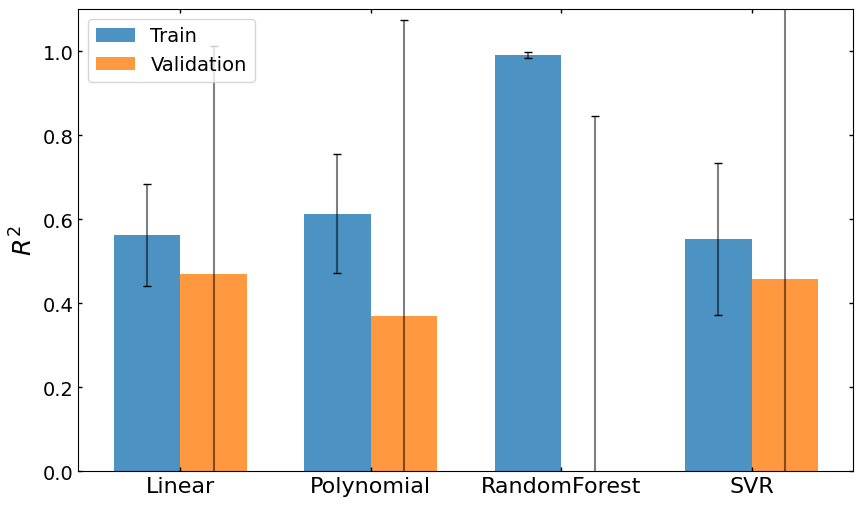

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data - replace with your actual MSE and R-squared results
models = ['Linear', 'Polynomial', 'RandomForest','SVR']
mse_values = {
    'Train': [mse_mu_linear[0], mse_mu_poly[0], mse_mu_rf[0],mse_mu_svr[0]],
    'Validation': [mse_mu_linear[1], mse_mu_poly[1], mse_mu_rf[1],mse_mu_svr[1]]

}

mse_values_std = {
    'Train': [mse_sigma_linear[0], mse_sigma_poly[0], mse_sigma_rf[0],mse_sigma_svr[0]],
    'Validation': [mse_sigma_linear[1], mse_sigma_poly[1], mse_sigma_rf[1],mse_sigma_svr[1]]
}

r2_values = {
    'Train': [r2_mu_linear[0], r2_mu_poly[0], r2_mu_rf[0],r2_mu_svr[0]],
    'Validation': [r2_mu_linear[1], r2_mu_poly[1], r2_mu_rf[1],r2_mu_svr[1]]
}

r2_values_std = {
    'Train': [r2_sigma_linear[0], r2_sigma_poly[0], r2_sigma_rf[0],r2_sigma_svr[0]],
    'Validation': [r2_sigma_linear[1], r2_sigma_poly[1], r2_sigma_rf[1],r2_sigma_svr[1]]
}

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

# Plot MSE with error bars
fig1, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, mse_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x + width/2, mse_values['Validation'], width, yerr=mse_values_std['Validation'], label='Validation', color='tab:orange', capsize=3, alpha=0.8)

# Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel('MSE', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 2.1, 0.5),fontsize=14)
ax.set_ylim([0, 2.1])
plt.show()

# Plot R-squared with error bars
fig2, ax = plt.subplots(figsize=(10, 6))
# ax.bar(x - width/2, r2_values['Train'], width, yerr=r2_values_std['Train'], label='Train', color='green', capsize=3)
# ax.bar(x + width/2, r2_values['Validation'], width, yerr=r2_values_std['Validation'], label='Validation', color='red', capsize=3)
bars1 = ax.bar(x - width/2, r2_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x + width/2, r2_values['Validation'], width, yerr=mse_values_std['Validation'],
               label='Validation', color='tab:orange', capsize=3, alpha=0.8)
# Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel(r'$R^2$', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 1.1, 0.2),fontsize=14)
ax.set_ylim([0, 1.1])
plt.show()


Result from ResNet18. For traing detail please see the Composite_ML_CNNs_model.ipynb

In [ ]:
# Final Statistics Across All Folds for ResNet18:
# Train MSE: 0.2121 ± 0.1531
# Train R-squared: 0.8716 ± 0.0871
# Validation MSE: 0.3392 ± 0.0937
# Validation R-squared: 0.7783 ± 0.0752
# Test MSE: 0.1827 ± 0.0722
# Test R-squared: 0.8629 ± 0.0542

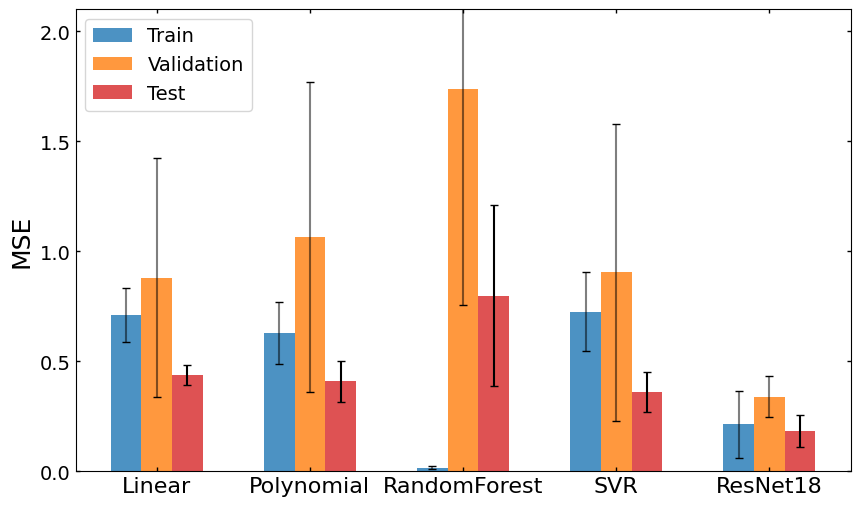

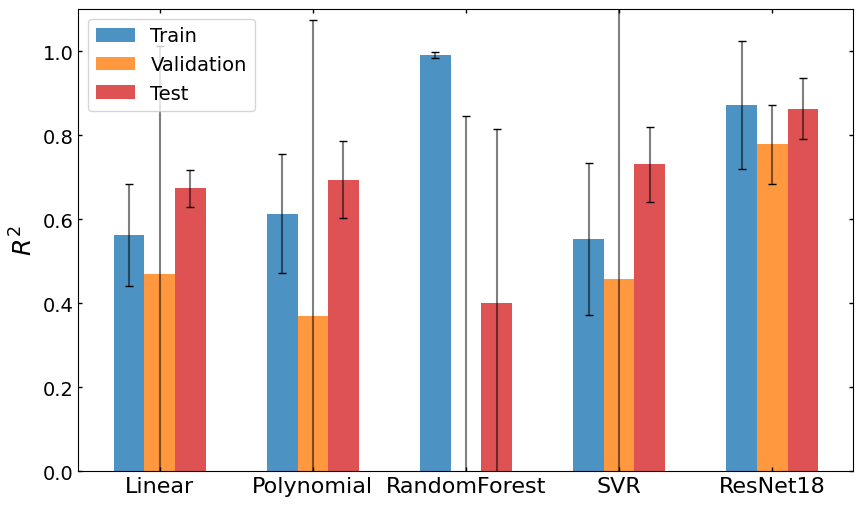

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data - replace with your actual MSE and R-squared results
models = ['Linear', 'Polynomial', 'RandomForest','SVR', 'ResNet18']
mse_values = {
    'Train': [mse_mu_linear[0], mse_mu_poly[0], mse_mu_rf[0],mse_mu_svr[0], 0.2121],
    'Validation': [mse_mu_linear[1], mse_mu_poly[1], mse_mu_rf[1],mse_mu_svr[1], 0.3392],
    'Test': [mse_mu_linear[2], mse_mu_poly[2], mse_mu_rf[2],mse_mu_svr[2],0.1827]
}

mse_values_std = {
    'Train': [mse_sigma_linear[0], mse_sigma_poly[0], mse_sigma_rf[0],mse_sigma_svr[0], 0.1531],
    'Validation': [mse_sigma_linear[1], mse_sigma_poly[1], mse_sigma_rf[1],mse_sigma_svr[1], 0.0937],
    'Test': [mse_sigma_linear[2], mse_sigma_poly[2], mse_sigma_rf[2],mse_sigma_svr[2], 0.0722]
}

r2_values = {
    'Train': [r2_mu_linear[0], r2_mu_poly[0], r2_mu_rf[0],r2_mu_svr[0], 0.8716],
    'Validation': [r2_mu_linear[1], r2_mu_poly[1], r2_mu_rf[1],r2_mu_svr[1], 0.77832],
    'Test': [r2_mu_linear[2], r2_mu_poly[2], r2_mu_rf[2],r2_mu_svr[2], 0.8629]
}

r2_values_std = {
    'Train': [r2_sigma_linear[0], r2_sigma_poly[0], r2_sigma_rf[0],r2_sigma_svr[0], 0.0871],
    'Validation': [r2_sigma_linear[1], r2_sigma_poly[1], r2_sigma_rf[1],r2_sigma_svr[1], 0.0752],
    'Test':[r2_sigma_linear[2], r2_sigma_poly[2], r2_sigma_rf[2],r2_sigma_svr[2], 0.0542]
}

x = np.arange(len(models))  # label locations
width = 0.2  # bar width

# Plot MSE with error bars
fig1, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, mse_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x, mse_values['Validation'], width, yerr=mse_values_std['Validation'], label='Validation', color='tab:orange', capsize=3, alpha=0.8)
bars3 = ax.bar(x + width, mse_values['Test'], width, yerr=mse_values_std['Test'], label='Test', color='tab:red', capsize=3, alpha=0.8)

# # Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel('MSE', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 2.1, 0.5),fontsize=14)
ax.set_ylim([0, 2.1])
plt.show()

# Plot R-squared with error bars
fig2, ax = plt.subplots(figsize=(10, 6))
# ax.bar(x - width, r2_values['Train'], width, yerr=r2_values_std['Train'], label='Train', color='green', capsize=3)
# ax.bar(x, r2_values['Validation'], width, yerr=r2_values_std['Validation'], label='Validation', color='red', capsize=3)
bars1 = ax.bar(x - width, r2_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x, r2_values['Validation'], width, yerr=mse_values_std['Validation'],
               label='Validation', color='tab:orange', capsize=3, alpha=0.8)
bars3 = ax.bar(x + width, r2_values['Test'], width, yerr=mse_values_std['Test'], label='Test', color='tab:red', capsize=3, alpha=0.8)

# Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars
for bar in bars3.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel(r'$R^2$', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 1.1, 0.2),fontsize=14)
ax.set_ylim([0, 1.1])
plt.show()
